In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 23 11:51:41 2016
数据库基本操作，从配置文件中读取基本配置信息
@author: lywen
"""
import traceback
import datetime as dt
import time
def getmongo():
    """获取mongo配置"""
    user = 'mongo'
    password ='mongo123456'
    host='10.4.32.21'
    port=27017
    db='fes'
    return user,password,host,port,db
class database(object):
    """
    数据库操作抽象类
    """
    def __init__(self,db,user,password,host,port):
        self.db = db## 数据库实例
        self.user = user ## 用户
        self.password = password ##密码
        self.host = host ##数据库IP
        self.port = port ## 数据库端口
        
    def connect(self):
        """
        数据库连接
        """
        pass
        
    def update(self,sql):
        """
        数据update更新操作
        """
        pass
    
    def insert(self,sql):
        """
        数据插入操作
        """
        pass
        
    def create(self,tablename):
        """
        创建表
        """
        pass
    
    def select(self,sql):
        """
         数据查询
        """
        pass
    
    def run(self):
        """
        运行
        """
        pass
    
    def close(self):
        """
        关闭连接
        """
        pass
    
   
   
class mongodb(database):
    """
    mongo数据库相关操作
    """
    def __init__(self):
        user,password,host,port,db = getmongo()
        database.__init__(self,db,user,password,host,port)##继承父类的__init__方法
        self.connect()
        
    def connect(self):
        """
        连接mongo数据库
        """
        from pymongo import MongoClient
        try:
            self.Client = MongoClient(host=self.host, port=self.port)
            
            db = self.Client[self.db]
            if self.host !='127.0.0.1':
               db.authenticate(name=self.user,password=self.password)
            self.__conn = db
        except:
            traceback.print_exc()
            #logs('database','mongodb','connect',traceback.format_exc())
            self.__conn = None


    def remove(self): 
        """
        清楚爬虫已经完成的任务
        """
        Now =  dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        try:
            count = self.__conn.client['taskdb']['kline'].count({'status':2})
            if count >10000:
                
                self.__conn.client['taskdb']['kline'].delete_many({'status':2})
                print u"%s 清除Kline任务成功"%Now
            else:
                 print u"%s  Kline任务总数为%d条，未清除任务"%(Now,count)
        except:
            pass
        
    def backup(self):
            """
             备份数据
            """
            t  =time.time()
            #db = self.__conn.get_collection('kline')
            Time = (dt.datetime.now() - dt.timedelta(1)).strftime('%Y-%m-%d %H:%M:%S')
            Now =  dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            types = ['0','1','2','3','4']
            
            kline = self.__conn.client['fes'].get_collection('kline').find({'type':{'$in':types},'Time':{'$lt':Time}})
            backdb = self.__conn.client['backdb']
            klinebackup = backdb['kline']
            
            print u"%s kline开始备份数据,备份数据总量为:%d; "%(dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),kline.count())
            for x in kline:
                try:
                   x.update({'backtime':Now})
                   klinebackup.insert_one(x)##备份Kline数据到backdb中
                except:
                    traceback.print_exc()
            
            try: 
            ###备份成功后，删除原表中的数据
                self.__conn.client['fes'].get_collection('kline').delete_many({'type':{'$in':types},'Time':{'$lt':Time}})
               
            except:
                traceback.print_exc()
                
            print u"%s 备份数据成功, "%(dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),    
            print u"""数据备份完成，用时:%ds"""%(time.time()-t)
    
    def mongobackup(self):
       
        Now =  dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print "%s爬虫脚步开始备份 "%Now,
        data = self.__conn.client['projectdb'].get_collection('projectdb').find()
        newdata = data.clone()
        projectdb = self.__conn.client['backdb'].get_collection('projectdb')
        for x in newdata:
            new_x = {'name':x.get('name'),'backtime':Now,'project':x}
            try:
               projectdb.insert_one(new_x)
            except:
               traceback.print_exc()
        print "%s爬虫脚步备份完成"%Now     
        
    def close(self):
        """
        关闭连接
        """
        self.__conn.client.close()
        
    def getConn(self):
        return self.__conn


In [ ]:
if __name__ == '__main__':
    mongo  = mongodb()
    mongo.remove()
    mongo.backup()
    mongo.mongobackup()
    mongo.close()

In [ ]:
## var模型数据
import numpy as np 
import pandas as pd

In [ ]:
y = np.random.normal(size=1000,loc=0.0, scale=0.1)
x = range(1000)
data = pd.DataFrame({'var':y})

In [ ]:
data.to_csv('../var.csv',index=False,headers=False)

In [ ]:
from ggplot import *

In [ ]:
ggplot(aes(x='var'),data=data)+geom_density()+xlab('%')+ylab('p')+labs(title='var')

In [ ]:
import datetime as dt

In [ ]:
##
y = np.random.normal(size=92,loc=100, scale=2)
date = map(lambda x:dt.datetime(2016,9,1)+dt.timedelta(x),range(92))
upper = ((y+20)).tolist()
lower = ((y-20)).tolist()
y = y.tolist()
Y = y+upper+lower
group = np.repeat('mean',92).tolist() + np.repeat('lower',92).tolist()+np.repeat('upper',92).tolist()
data = pd.DataFrame({'y':Y,'x':date+date+date,'group':group})
data.to_csv('../value.csv',index=False)
#data['x'] = data['x'].map(lambda x:dt.datetime.strptime(str(x),'%Y-%m-%d'))
#ggplot(aes(x=x,y=y),data=data)+geom_line()+xlab('%')+ylab('p')+labs(title='var')

In [ ]:
ggplot(aes(x='x',y='y',color='group'),data=data)+geom_line()+xlab('date')+ylab('value')

In [1]:
def floatrange(start,stop,steps):
    ''' Computes a range of floating value.
        
        Input:
            start (float)  : Start value.
            end   (float)  : End value
            steps (integer): Number of values
        
        Output:
            A list of floats
        
        Example:
            >>> print floatrange(0.25, 1.3, 5)
            [0.25, 0.51249999999999996, 0.77500000000000002, 1.0375000000000001, 1.3]
    '''
    return [start+float(i)*(stop-start)/(float(steps)-1) for i in range(steps)]
 


In [2]:
def density(value,length):
    """
    value = [0.23, -0.03, 0.09, -0.05, 0.03, -0.13, 0.02, -0.04, -0.03,...,]
    """
    value = sorted(value)##对数组进行排序
    N = len(value)## 数组长度
    Max = max(value)##计算最大值
    Min = min(value)##计算最小值
    ##分位数
    
    Quartile = floatrange(Min,Max,length)##划分length个区间
   
    n = length##分位数区间个数
    
    densitylist = np.repeat(0,n).tolist()
    tempvalue = value[:]
    while tempvalue!=[]:
        x = tempvalue.pop()
        
        for i in range(n-1):
               if x>= Quartile[i] and x<Quartile[i+1]:
                  densitylist[i]+= 1
                  
                  if x==Max:
                          densitylist[i+1]+= 1
                  break
               
    return densitylist,Quartile

In [2]:
import numpy as np
import pandas as pd

In [10]:
n=10000
value = np.random.normal(0,0.1,size=n).tolist()

y,x = np.histogram(value,bins='scott',density=True)
x = (x+ (x[1]-x[0])/2.0)[:-1]
data = pd.DataFrame({'x':x,'y':y})

In [19]:
value = sorted(value)
value[int(0.05*(len(value)-1))]

-0.1601447617133019

In [8]:
%matplotlib inline
from ggplot import *

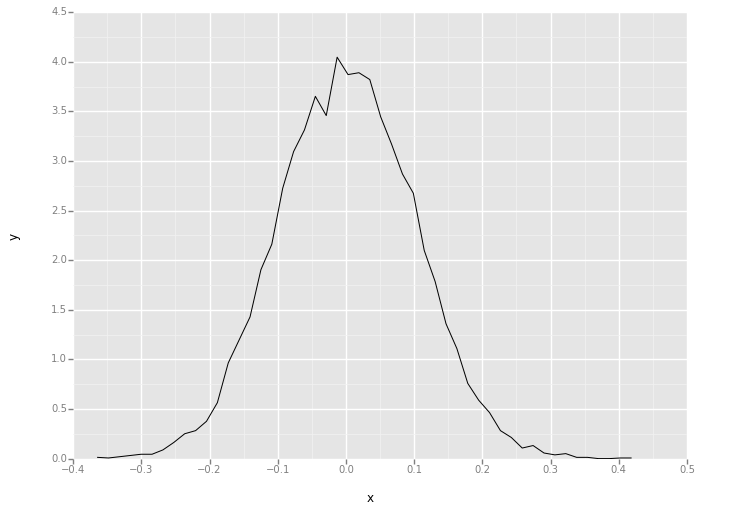

<ggplot: (293003449)>

In [11]:
ggplot(aes(x='x',y='y'),data=data)+geom_line()

In [21]:
tempdata = pd.DataFrame({'x':value})

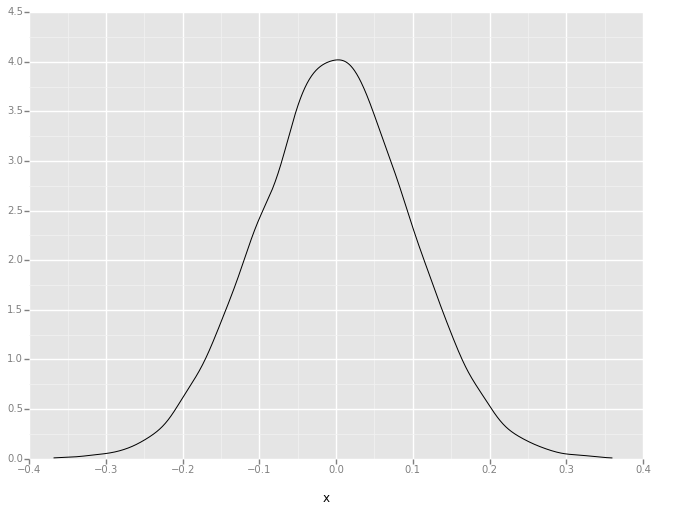

<ggplot: (293740805)>

In [22]:
ggplot(aes(x='x'),data=tempdata)+geom_density()